# Quick Overview

This tutorial will help you get started with basic usage of the FanInSAR library. We will cover the following topics:

- How to initialize a dataset
- How to query values from dataset by given points/bounding boxes/polygons
- How to operate time series processing (e.g., unwrapping error correction, NSBAS inversion, etc.)
- How to save the processed results into tiff/kml(kmz) files

## Imports

Customarily, we import FanInSAR as follows:

In [1]:
from pathlib import Path
import numpy as np

import faninsar as fis
from faninsar import datasets, NSBAS, query, constants, cmaps

## Load InSAR datasets

FanInSAR provides a series of [datasets](#geo_datasets) to load well-known InSAR products. Here we will use the [HyP3S1](#faninsar.datasets.HyP3S1) for example, which is used to load the HyP3 Sentinel-1 frame dataset. 

::: {tip}
If [datasets](#geo_datasets) provided by FanInSAR do not meet your requirements, you can also create your own dataset class following the 
tutorial: [Custom Datasets](#custom_datasets)
:::


### Initialize a dataset

To initialize the [HyP3S1](#faninsar.datasets.HyP3S1) class, you only need to provide the root directory of the HyP3 data. All unwrapped interferogram and coherence files stored in the root directory, including the subdirectories, will be automatically scanned. 

In [2]:
root_dir = Path("/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/descending_roi/")
ds_unw = datasets.HyP3S1(root_dir, fill_nodata=True)

:::{tip}
- You can also directly provide the ``paths_unw`` and ``paths_coh`` arguments to specify the paths of the unwrapped and coherence files. In this case, the ``root_dir`` argument will be ignored. 
- Only common pairs of the unwrapped interferogram and coherence files will be used. The rest of the files will be ignored automatically.
:::


:::{admonition} More initialization parameters
:class: dropdown

Below are the common parameters to initialize a dataset:

- **crs, res, resampling**:  
  - If the dataset files are not aligned with the specified `crs` (Coordinate Reference System) or `res` (resolution), the warp process, such as resampling and reprojection, will be performed to align the dataset files with the specified `crs` and `res` automatically. ([Here](#warp_example) are some examples of usage)
  - The `resampling` parameter is employed to define the resampling algorithm used in the warp process. The default value is `Resampling.nearest`. More resampling algorithms can be found [here](#rasterio.enums.Resampling).
- **fill_nodata**: If `True`, the nodata values in raster files will be interpolated using inverse distance weighting method provided by the [rasterio.fill.fillnodata()](#rasterio.fill.fillnodata).
- **roi**: region of interest, which defines the specific area to be loaded from the dataset. If left as `None`, the combined boundary of all files within the dataset will be utilized.
- **verbose**: Enabling `verbose=True` will display the dataset processing information. To suppress this output, set the parameter to `False`.
:::

### Interferogram dataset

[HyP3S1](#faninsar.datasets.HyP3S1) is a subclass of [RasterDataset](#faninsar.datasets.RasterDataset) and provides the same functionalities/properties as [RasterDataset](#faninsar.datasets.RasterDataset). You can view interferogram file by directly calling `files` property. The file paths and whether the file is valid or not will be displayed in the DataFrame format.

In [3]:
ds_unw.files

,paths,valid
0,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True
1,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True
2,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True
3,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True
4,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True
...,...,...
2745,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True
2746,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True
2747,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True
2748,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True


We keep the same API with `rasterio` for the dataset, so you can use directly access the resolution, bounds, and other properties of the dataset just like using rasterio. 

:::{important}
The `res`, `crs`, `dtypes` and `nodata` are the output properties of the dataset, which can be specified by the user when initializing the dataset. The actual properties of the raster files may be different from the those properties.
:::

In [4]:
print(f" res: {ds_unw.res}\n bounds: {ds_unw.bounds}\n crs: {ds_unw.crs}\n dtype: {ds_unw.dtype}\n nodata: {ds_unw.nodata}")

 res: (40.0, 40.0)
 bounds: BoundingBox(left=443501.82025355106, bottom=4263758.21737383, right=536101.820253551, top=4335118.21737383, crs=EPSG:32647)
 crs: EPSG:32647
 dtype: float32
 nodata: 0.0


### Coherence dataset

The coherence dataset can be accessed by the `coh_dataset` property of the [HyP3S1](#faninsar.datasets.HyP3S1) object. The coherence dataset is also a [RasterDataset](#faninsar.datasets.RasterDataset) object, so you can access the properties of the coherence dataset just like the unwrapped interferograms.

In [5]:
ds_coh = ds_unw.coh_dataset
ds_coh.files

,paths,valid
0,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True
1,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True
2,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True
3,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True
4,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True
...,...,...
2745,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True
2746,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True
2747,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True
2748,/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/desce...,True


## Query values by Points/Boxes/Polygons

FanInSAR provides a [query](#query_module) module, which defines a series of classes to query/sample values from the dataset by given points, bounding boxes, or polygons and store the results of the queries.

### Define queries

:::{admonition} Query types in FanInSAR
:class: dropdown

There are four types of queries in the query module: [Points](#faninsar.query.Points), [BoundingBox](#faninsar.query.BoundingBox),  [Polygons](#faninsar.query.Polygons), and [GeoQuery](#faninsar.query.GeoQuery):

- **Points**: A collection of points, can be used to sample multiple pixel values from GeoDataset.
- **BoundingBox**: A bounding box, can be used to sample rectangular region values from GeoDataset.
- **Polygons**: A collection of polygons, can be used to sample multiple polygon values from GeoDataset.
- **GeoQuery**: A combination of `Points`, `BoundingBox`, and `Polygons`. It is highly recommended if you want to sample values using multiple query types simultaneously.
:::


Below is an example of how to define a `GeoQuery` containing both reference points and a bounding box

In [6]:
# initialize a Points from a shape file, which contains reference points
ref_file = "/Volumes/Data/GeoData/YNG/ARPs.geojson"
ref_points = query.Points.from_shapefile(ref_file)

# define a bounding box for the region of interest
roi = query.BoundingBox(
    98.86517887, 38.78630936, 98.90998476, 38.83929150, crs="EPSG:4326"
)

# define a GeoQuery, which is a combination of a bounding box and a set of reference points
geo_query = query.GeoQuery(boxes=roi, points=ref_points)

### Query values by `GeoQuery`

There are two methods to query values from a dataset: using `[]` and using the `query()` method. 

#### Query by `[]`

This is a direct querying method, suitable when you only need to retrieve all valid pairs.

In [7]:
unw_sample1 = ds_unw[geo_query]

Loading Interferogram Files: 100%|██████████| 2750/2750 [01:08<00:00, 40.24 files/s]


#### Query by `query()` method

This method offers more flexibility, allowing you to query the values of a subset of pairs by specifying the `pairs` parameter.

:::{admonition} Strategy for selecting pairs
:class: dropdown

In this tutorial, two components are considered in the selection of interferometric pairs in the SBSA network:

- **Pairs(days<=60)**: All interferometric pairs with temporal baselines of lease than 60 days. 
- **Pairs(nearest winters)**: All available interferometric pairs between adjacent winters are constructed. Specifically, for each winter, all acquisitions from January 1st to March 31st for each year are selected, during which period the active layer is typically completely frozen. 

Adding pairs that link to the nearest winters can help to mitigate the cumulative bias in deformation time series caused by multi-looking and spatial filtering operations in SBAS.

:::{admonition} Reference
:class: dropdown, tip

Systematic phase biases in InSAR time series can be caused by the multi-looking and spatial filtering operations in SBAS:

- Ansari, H., De Zan, F., Parizzi, A., 2021. Study of Systematic Bias in Measuring Surface Deformation With SAR Interferometry. IEEE Transactions on Geoscience and Remote Sensing 59, 1285–1301. https://doi.org/10.1109/TGRS.2020.3003421
- Zheng, Y., Fattahi, H., Agram, P., Simons, M., Rosen, P., 2022. On Closure Phase and Systematic Bias in Multilooked SAR Interferometry. IEEE Transactions on Geoscience and Remote Sensing 60, 1–11. https://doi.org/10.1109/TGRS.2022.3167648
- Maghsoudi, Y., Hooper, A.J., Wright, T.J., Lazecky, M., Ansari, H., 2022. Characterizing and correcting phase biases in short-term, multilooked interferograms. Remote Sensing of Environment 275, 113022. https://doi.org/10.1016/j.rse.2022.113022

For the permafrost regions, The bias can be effectively mitigated by adding interferometric pairs that link to the nearest winters:

- Fan, C., Liu, L., Zhao, Z., Mu, C., 2024. Pronounced Underestimation of Surface Deformation due to Unwrapping Errors over Tibetan Plateau Permafrost by Sentinel-1 InSAR: Identification and Correction (In Review).

:::
:::

In [8]:
pairs = ds_unw.pairs

# select the pairs within a specific time period
period_mask = pairs.where(pairs["2017":"2023-04"], return_type="mask")
# prepare the mask for the two types of pairs
mask_nearest_winter = (
    period_mask
    & (pairs.days > 180)
    & (pairs.days < 360 + 180)
    & (pairs.primary.month.map(lambda x: x in [1, 2, 3]))
    & (pairs.secondary.month.map(lambda x: x in [1, 2, 3]))
)
mask_60 = (pairs.days <= 60) & (period_mask) 

# combine the two masks to select the pairs
pairs_mask = mask_60 | mask_nearest_winter
pairs_used = pairs[pairs_mask]

# query the interferogram and coherence files with the selected pairs
unw_sample2 = ds_unw.query(geo_query, pairs=pairs_used)
coh_sample2 = ds_coh.query(geo_query, pairs=pairs_used)

Loading Coherence Files: 100%|██████████| 1090/1090 [00:23<00:00, 47.16 files/s]


### Results of queries

:::{admonition} Properties of query results 
:class: dropdown
[QueryResult](query_result) class is used to store the query results. It contains the following four properties:

- **points**: Result of the `Points` query.
- **boxes**: Result of the `BoundingBox` query.
- **polygons**: Result of the `Polygons` query.
- **query**: The original `GeoQuery` instance used to query the dataset.
:::

check the query results for `[]` method

In [9]:
unw_sample1

QueryResult(
    points=PointsResult(files:2750, points:107),
    boxes=BBoxesResult(files:2750, height:147, width:97),
    polygons=None,
    query=GeoQuery(points=Points(count=107, crs='EPSG:4326'), boxes=[1 BoundingBox], polygons=None)
)

In [10]:
# Following steps will only use unw_sample2 for demonstration
del unw_sample1

check the query results for `query()` method

In [11]:
unw_sample2

QueryResult(
    points=PointsResult(files:1090, points:107),
    boxes=BBoxesResult(files:1090, height:147, width:97),
    polygons=None,
    query=GeoQuery(points=Points(count=107, crs='EPSG:4326'), boxes=[1 BoundingBox], polygons=None)
)

:::{tip}
For each query type, the masked numpy array values are stored in the `data` property, and the corresponding dimensions are stored in the `dims` property.
:::

We typically take the mean phase values of multiple reference points as the final reference point value. In FanInSAR, re-referencing process can be easily achieved by the code below:

In [12]:
# calculate the mean phase values of multiple reference points
ref_values = unw_sample2.points.data.mean(axis=1)

# re-referencing the phases
unw_img = unw_sample2.boxes.data - ref_values[:, None, None]

In [13]:
# load the coherence data
coh_img = coh_sample2.boxes.data

## Time-series processing

### Unwrapping error correction

Here, we will demonstrate how to correct the unwrapping errors in the interferograms using the method presented in the following reference:

:::{admonition} Reference
:class: dropdown, tip
- Poster: Fan, C., Liu, L., Mu, C., 2023. ["Does InSAR Time Series Using C-band Sentinel-1 Data Underestimate Surface Deformation Over Permafrost Regions on Qinghai-Tibetan Plateau?"](https://agu23.ipostersessions.com/default.aspx?s=7E-2A-74-4D-47-0B-85-B9-6A-ED-25-42-9B-4A-48-87) Presented at the AGU23, AGU. https://agu23.ipostersessions.com/default.aspx?s=7E-2A-74-4D-47-0B-85-B9-6A-ED-25-42-9B-4A-48-87

- Paper: Fan, C., Liu, L., Zhao, Z., Mu, C., 2024. Pronounced Underestimation of Surface Deformation due to Unwrapping Errors over Tibetan Plateau Permafrost by Sentinel-1 InSAR: Identification and Correction (In Review).
:::

In this tutorial, the interferograms with temporal baselines less than 12 days are treated as the reliable `edge pairs`, and are used to correct the unwrapping errors in the `diagonal pairs`, which temporal baselines are longer than 12 days.

First, we need to generate loops with given `edge pairs`. This can be easily achieved by the [to_loops()](#faninsar.Pairs.to_loops) method of the `Pairs` class by specifying the `edge_pairs` parameter.

In [14]:
# filter the edges pairs with temporal baseline less than 12 days
edge_pairs = pairs_used[pairs_used.days <= 12]

# get the loops with edges pairs
loops = pairs_used.to_loops(max_acquisition=6, edge_pairs=edge_pairs)
loops

Loops(
    loops=664,
    pairs=840,
    edge_pairs=176,
    diagonal_pairs=664
)

Then, we can correct the unwrapping errors in the `diagonal pairs` using the un-closure phases of the loops. This can be done by the [calculate_u()](#faninsar.NSBAS.inversion.calculate_u) function in the `NSBAS` module.

In [15]:
# reshape the unw_img and coh_img to 2D array (n_img, n_pixel) for calculation
n_img, n_row, n_col = unw_img.shape
unw = unw_img.reshape(n_img, -1)
coh = coh_img.reshape(n_img, -1)

# =============================================================================
# there are cases that not all the pairs are used in the loops
# so we need to select the pairs that are used in the loops
# =============================================================================

idx = pairs_used.where(loops.pairs)
unw_used = unw[idx]

# calculate the correction term u
u = np.zeros_like(unw, dtype=np.float32)
u[idx] = np.round(NSBAS.calculate_u(loops, unw_used))

# calculate the corrected interferometric phases
unw_c = unw - 2 * np.pi * u

### NSBAS inversion chain

#### Convert phase to deformation 

FanInSAR provides a [PhaseDeformationConverter](#faninsar.PhaseDeformationConverter) class to convert values between phase and deformation. You can call the `phase2deformation()` method to convert the unwrapped phase to deformation in millimeters (mm).

In [16]:
# initialize a PhaseDeformationConverter instance with the frequency of Sentinel-1
pdc = fis.PhaseDeformationConverter(constants.freq.SENTINEL1)

# convert the unwrapped phases to deformation
d = pdc.phase2deformation(unw)
d_c = pdc.phase2deformation(unw_c)

#### Mask low coherence pixels

Before the NSBAS inversion, we typically mask the pixels with low coherence values. This can be done by [numpy.ma](numpy.ma) module. Following is an example of how to mask the pixels with coherence values less than 0.3.

In [17]:
t_coh = 0.3

d = np.ma.array(d, mask=coh < t_coh)
d_c = np.ma.array(d_c, mask=coh < t_coh)

:::{tip}
the masked numpy array [MaskedArray](numpy.ma.MaskedArray) still stores the raw data, and can be accessed by the `data` property.
:::

#### Define time series model

[TimeSeriesModel](#tsmodels) module provides a series of time series models. Here we use the [AnnualSemiannualSinusoidal](#faninsar.NSBAS.tsmodels.AnnualSemiannualSinusoidal) model as an example.

:::{tip}
If None of the models in the [TimeSeriesModel](#tsmodels) module meet your requirements, you can define your own time series model following the tutorial: [Custom Time Series Models](#custom_tsmodels).
:::

In [18]:
ts_model = NSBAS.AnnualSemiannualSinusoidal(pairs_used.dates)

:::{admonition} Initialize a time series model
:class: dropdown

- For the mathematical models, you typically only need to provide the `dates` of acquisitions to initialize a time series model. 
- For the more complex physical models, you need to check the specific initialization parameters in the documentation. For example, the [FreezeThawCycleModelWithVelocity](#faninsar.NSBAS.tsmodels.FreezeThawCycleModelWithVelocity) model requires the `dates` and `ftc` parameters to be specified.
:::

#### Operate NSBAS inversion

:::{admonition} Theory of NSBAS inversion
:class: dropdown

The objective of the SBAS/NSBAS inversion is to estimate the `m` for the equation:

```{math}
:label: eq_inversion
\mathbf{d=Gm}
```

where:

- **m** (model domain): a vector of `N-1` incremental deformations of adjacent `N` SAR acquisitions (and the time series model parameters for NSBAS inversion). 
- **d** (data domain): a vector of the deformation/(unwrapped phases) of interferograms. 
- **G**: a design matrix that maps the values in data domain `d` to the model domain `m`.

The least squares solution is typically used to solve the equation {eq}`eq_inversion` to estimate the `m`.

:::{admonition} Reference
:class: tip, dropdown

Following papers are recommended for understanding the NSBAS inversion method:
- López-Quiroz, P., Doin, M.-P., Tupin, F., Briole, P., Nicolas, J.-M., 2009. Time series analysis of Mexico City subsidence constrained by radar interferometry. Journal of Applied Geophysics, Advances in SAR Interferometry from the 2007 Fringe Workshop 69, 1–15. https://doi.org/10.1016/j.jappgeo.2009.02.006
- Fan, C., Mu, C., Liu, L., Zhang, T., Jia, S., Wang, S., Sun, W., Zhao, Z., 2024. Time-Series models for ground subsidence and heave over permafrost in InSAR processing: New improvements and comprehensive assessments (In Review).
:::
:::

FanInSAR streamlines the process of generating the design matrix `G` and data vector `d` through the [NSBASMatrixFactory](#faninsar.NSBAS.inversion.NSBASMatrixFactory) class. After initializing this class, you can directly access the design matrix `G` and data vector `d` as properties.


In [19]:
matrix_factory = NSBAS.NSBASMatrixFactory(d, pairs_used, ts_model)

print(matrix_factory.d.shape, matrix_factory.G.shape)

(1273, 14259) (1273, 188)


FanInSAR also streamlines the process of solving the least squares problem to estimate the `m` through the [NSBASInversion](#faninsar.NSBAS.inversion.NSBASInversion) class. After initializing this class, you can directly perform the inversion by calling the `inverse()` method.

In [20]:
sbas_inverse = NSBAS.NSBASInversion(matrix_factory, device="cpu")
inc, params, residual_pair, residual_tsm = sbas_inverse.inverse()

# calculate the cumulative deformation by the incremental deformation
cum = np.cumsum(inc, axis=0)
# insert a zero row for the first acquisition
cum = np.insert(cum, 0, 0, axis=0)

  NSBAS inversion:   0%|          | 0/7130 [00:00<?, ?Batch/s]

  NSBAS inversion: 100%|██████████| 7130/7130 [00:12<00:00, 581.80Batch/s]


:::{tip}
- FanInSAR uses the `PyTorch` library as the backend for the computation. Therefore, you can easily switch the computation between the `GPU` and `CPU` by specifying the `device` parameter. See the [torch.device](#torch.device) for more information.
- Low-level functions for the least squares problem, such as [censored_lstsq()](#faninsar.NSBAS.inversion.censored_lstsq) and [batch_lstsq()](#faninsar.NSBAS.inversion.batch_lstsq), are also provided in the [NSBAS.inversion](#tsmodels) module.
:::

perform NSBAS inversion for the **unwrapped phases that not been masked by the coherence values** for comparison.

In [21]:
matrix_factory = NSBAS.NSBASMatrixFactory(d.data, pairs_used, ts_model)
sbas_inverse = NSBAS.NSBASInversion(matrix_factory, device="cpu")
inc_r, params_r, residual_pair_r, residual_tsm_r = sbas_inverse.inverse()
cum_r = np.cumsum(inc_r, axis=0)
cum_r = np.insert(cum_r, 0, 0, axis=0)

  NSBAS inversion: 100%|██████████| 4753/4753 [00:12<00:00, 375.40Batch/s]


perform NSBAS inversion for the **corrected unwrapping phases** for comparison.

In [22]:
matrix_factory = NSBAS.NSBASMatrixFactory(d_c, pairs_used, ts_model)
sbas_inverse = NSBAS.NSBASInversion(matrix_factory, device="cpu")
inc_c, params_c, residual_pair_c, residual_tsm_c = sbas_inverse.inverse()
cum_c = np.cumsum(inc_c, axis=0)
cum_c = np.insert(cum_c, 0, 0, axis=0)

  NSBAS inversion: 100%|██████████| 4753/4753 [00:13<00:00, 357.84Batch/s]


### Results analysis

#### Amplitude comparison

The seasonal amplitude of deformation {math}`A_{dfm}` can be derived from the parameters of the time series model. For the [AnnualSemiannualSinusoidal](#faninsar.NSBAS.tsmodels.AnnualSemiannualSinusoidal) model, it can be calculated by:

```{math}
:label: eq_amplitude

A_{dfm} = 2\sqrt{a^2 + b^2}
```

where `a` and `b` are the coefficients of the annual components `sin(T)` and `cos(T)`

In [23]:
# check the model parameters
ts_model

AnnualSemiannualSinusoidal(
    dates: 183
    unit: day
    param_names: ['sin(T)', 'cos(T)', 'sin(T/2)', 'cos(T/2)', 'velocity', 'constant']
    G_br shape: (183, 6))
)

In [24]:
amplitude = 2 * np.sqrt(params[0] ** 2 + params[1] ** 2).reshape(n_row, n_col)
amplitude_r = 2 * np.sqrt(params_r[0] ** 2 + params_r[1] ** 2).reshape(n_row, n_col)
amplitude_c = 2 * np.sqrt(params_c[0] ** 2 + params_c[1] ** 2).reshape(n_row, n_col)

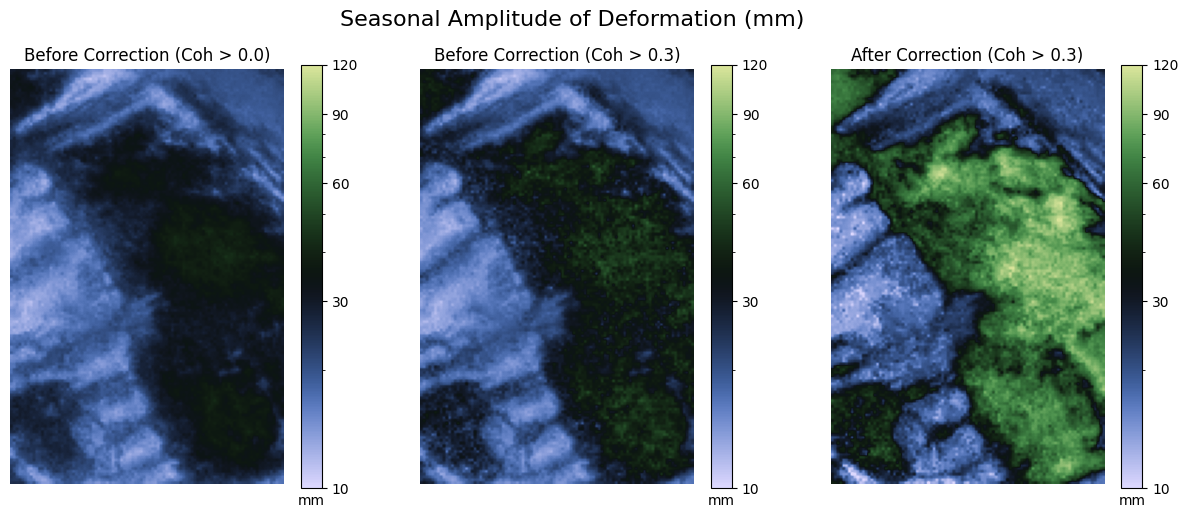

In [25]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

ticks = [10, 30, 60, 90, 120]
norm = LogNorm(vmin=10, vmax=120)

def plot_amplitude(amplitude, ax, title):
    im = ax.imshow(amplitude, cmap=cmaps.tofino, norm=norm)
    ax.axis("off")
    ax.set_title(title)
    # add color bar
    cb = fig.colorbar(im, ax=ax)
    cb.ax.set_yscale('log')
    cb.ax.set_xlabel('mm')
    cb.ax.set_yticks(ticks, labels=ticks)

fig, axs = plt.subplots(1, 3, figsize=(15, 5.5))
plot_amplitude(amplitude_r, axs[0], "Before Correction (Coh > 0.0)")
plot_amplitude(amplitude, axs[1], "Before Correction (Coh > 0.3)")
plot_amplitude(amplitude_c, axs[2], "After Correction (Coh > 0.3)")
fig.suptitle("Seasonal Amplitude of Deformation (mm)", fontsize=16)
plt.show()

#### Time series comparison

For a class inherited from `RasterDataset`, there is a method [row_col()](#faninsar.datasets.RasterDataset.row_col) to convert x and y coordinates to row and column index, and [xy()](#faninsar.datasets.RasterDataset.xy) to do the reverse. Therefore, we can easily find the row and column index of the given points for a given `roi` of the dataset.


In [26]:
# set/reset the region of interest (roi) of the dataset
# You can also set the roi when initializing a dataset
ds_unw.roi = roi

# define a point with latitude and longitude
point = query.Points([98.9027314, 38.8218616], crs="EPSG:4326")

# get the row and column of the point in the dataset for given roi
row_col = ds_unw.row_col(point, crs=point.crs)
row_col

array([[48, 81]])

In [27]:
row, col = row_col[0]
cum_point = cum.reshape(-1, n_row, n_col)[:, row, col]
cum_point_c = cum_c.reshape(-1, n_row, n_col)[:, row, col]

Since some pairs may have been masked by the coherence values, there may be some missing values (gaps) have been filled by the time series model. [Pairs](#faninsar.Pairs) class provides a method [parse_gaps()](#faninsar.Pairs.parse_gaps) to find the gaps in the time series by providing the `pairs_removed` parameter.

:::{note}
Theoretically, the gaps should be the temporal spans (or intervals) between the consecutive acquisitions. For simplicity, the end dates of the gaps will be returned for the [parse_gaps()](#faninsar.Pairs.parse_gaps) method.
:::

In [28]:
coh_point = coh.reshape(-1, n_row, n_col)[:, row, col]
pairs_removed = pairs_used[coh_point < t_coh]

# parse the gaps caused by the removed pairs
gaps = pairs_used.parse_gaps(pairs_removed)
gaps

array(['2018-11-20T00:00:00', '2019-05-31T00:00:00',
       '2019-11-27T00:00:00', '2020-06-06T00:00:00'],
      dtype='datetime64[s]')

In [29]:
# get the deformation values of the gaps filled by time series model
mask = np.isin(pairs_used.dates[1:], gaps)
gap_vals = cum_point[1:][mask]
gap_vals_c = cum_point_c[1:][mask]

Now we can compare the time series of deformation before and after the unwrapping error correction.

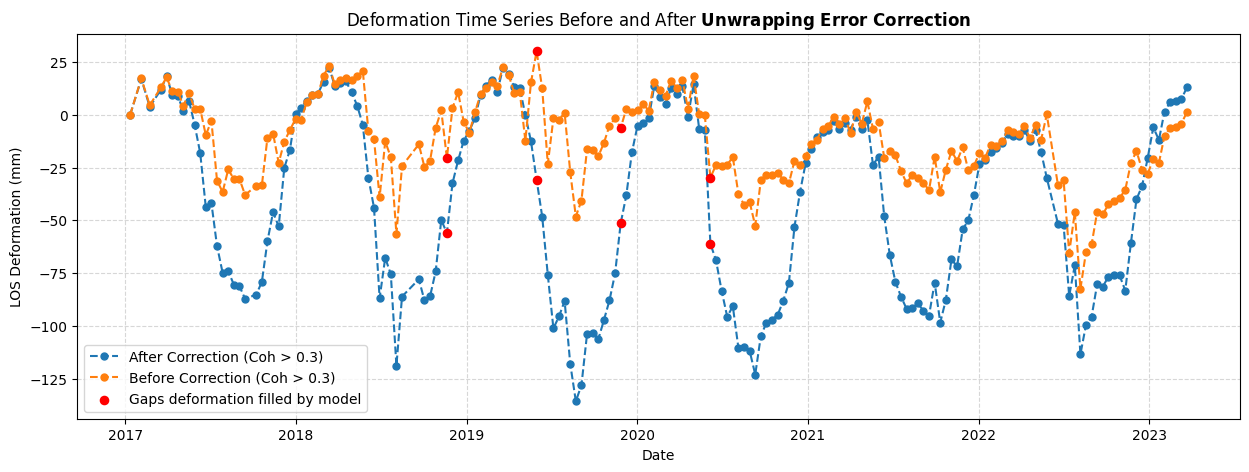

In [30]:
kwargs = dict(linewidth=1.5, ls="--", marker="o", markersize=5)
labels = [
    "Before Correction (Coh > 0.3)",
    "After Correction (Coh > 0.3)",
]

# plot deformation time series
plt.figure(figsize=(15, 5))
plt.plot(pairs_used.dates, cum_point_c, label=labels[1], **kwargs)
plt.plot(pairs_used.dates, cum_point, label=labels[0],  **kwargs)

# plot gaps deformation
kwargs = {"c": "r", "marker": "o", "s": 35, "zorder": 2}
point = plt.scatter(gaps, gap_vals, label="Gaps deformation filled by model", **kwargs)
point = plt.scatter(gaps, gap_vals_c, **kwargs)

plt.legend()
plt.grid(linestyle="--", alpha=0.5)
plt.ylabel("LOS Deformation (mm)")
plt.xlabel("Date")
plt.title(
    "Deformation Time Series Before and After $\\mathbf{Unwrapping\ Error\ Correction}$"
)
plt.show()

## Save results

For a dataset, you can save the processed results into tiff files by calling the [array2tiff()](#faninsar.datasets.RasterDataset.array2tiff) method.

In [31]:
out_file = "/Volumes/Data/GeoData/YNG/Sentinel1/Hyp3/descending_roi/cumulative_deformation.tif"
# ds_unw.array2tiff(cum_c, out_file, bounds=roi)
band_names = pairs_used.dates.strftime("%Y-%m-%d")
ds_unw.array2tiff(
    cum_c.reshape(-1, n_row, n_col),
    out_file, 
    bounds=roi, 
    band_names=band_names,
)